In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [4]:
@dataclass
class DeepseekArgs:
    max_seq_len: int = 4096 * 4  # 最大序列长度
    hidden_dim: int = 2048  # 模型维度
    n_heads: int = 16  # Attention 头数

    q_lora_rank: int = 0  # Query 的 LoRA rank
    kv_lora_rank: int = 512  # Key, Value 的 LoRA rank
    qk_nope_head_dim: int = 128  # Query, Key 的 NoPE 维度
    qk_rope_head_dim: int = 64  # Query, Key 的 RoPE 维度
    v_head_dim: int = 128  # Value 的维度

    original_seq_len: int = 4096  # 原始序列长度
    rope_theta: float = 10000.0  # 频率参数

In [ ]:
def precompute_freqs_cis(args: DeepseekArgs) -> torch.Tensor:
    dim = args.qk_rope_head_dim
    seqlen = args.max_seq_len
    base = args.rope_theta

    freqs = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    freqs = torch.outer(torch.arange(seqlen), freqs)

    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def norm(self, x):
        x = x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        return x

    def forward(self, x):
        x = self.norm(x.float()).type_as(x)
        return self.weight * x

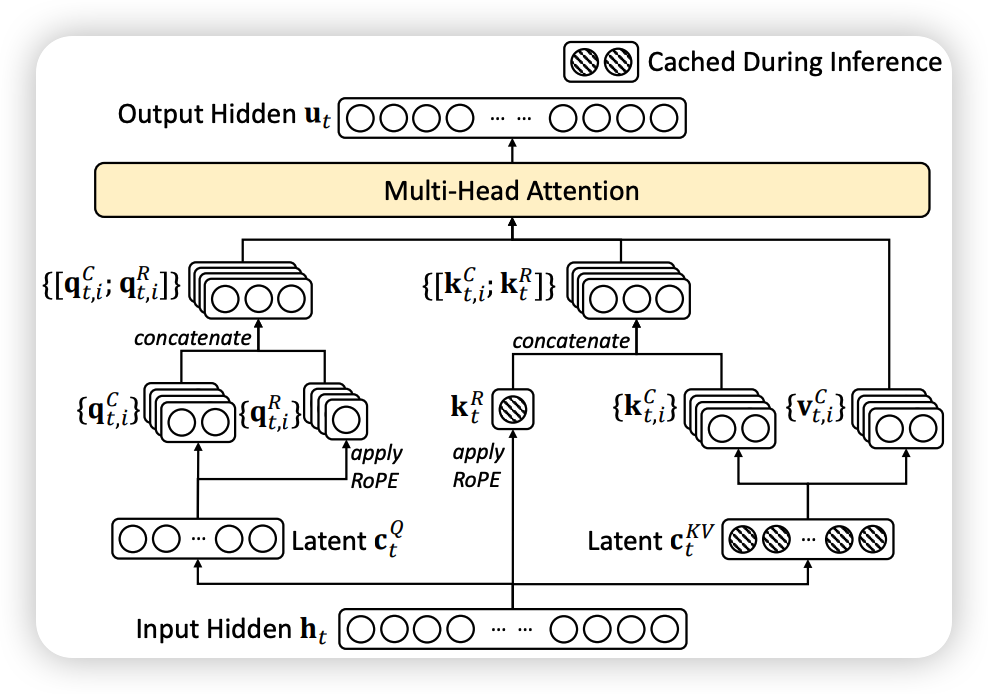

In [9]:
class MultiLatentAttention(nn.Module):
    def __init__(self, args: DeepseekArgs):
        super().__init__()
        self.hidden_dim = args.hidden_dim
        self.n_heads = args.n_heads

        self.q_lora_rank = args.q_lora_rank
        self.kv_lora_rank = args.kv_lora_rank

        self.qk_nope_head_dim = args.qk_nope_head_dim
        self.qk_rope_head_dim = args.qk_rope_head_dim

        self.qk_head_dim = self.qk_nope_head_dim + self.qk_rope_head_dim
        self.v_head_dim = args.v_head_dim

        self.wq_a = nn.Linear(self.hidden_dim, self.q_lora_rank)
        self.q_norm = RMSNorm(self.q_lora_rank)
        self.wq_b = nn.Linear(self.q_lora_rank, self.n_heads * self.qk_head_dim)

        self.wkv_a = nn.Linear(self.hidden_dim, self.kv_lora_rank + self.qk_rope_head_dim)
        self.kv_norm = RMSNorm(self.kv_lora_rank)
        self.wkv_b = nn.Linear(self.kv_lora_rank, self.n_heads * (self.qk_nope_head_dim + self.v_head_dim))

        self.wo = nn.Linear(self.n_heads * self.v_head_dim, self.hidden_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        q = self.wq_b(self.q_norm(self.wq_a(x)))
        q = q.view(batch_size, seq_len, self.n_heads, self.qk_head_dim)
        q_nope, q_rope = q.split([self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
        # q_rope = apply_rope(q_rope, freqs_cis)

        kv = self.wkv_a(x)
        kv, k_rope = kv.split([self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
        k_rope = k_rope.unsqueeze(-2)
        # k_rope = apply_rope(k_rope, freqs_cis)

        q = torch.cat([q_nope, q_rope], dim=-1)
        kv = self.wkv_b(self.kv_norm(kv))
        kv = kv.view(batch_size, seq_len, self.n_heads, self.qk_nope_head_dim + self.v_head_dim)
        k_nope, v = kv.split([self.qk_nope_head_dim, self.v_head_dim], dim=-1)
        k = torch.cat([k_nope, k_rope.expand(-1, -1, self.n_heads, -1)], dim=-1)

        scores = torch.einsum('bsnd,btnd->bsnt', q, k)

        if mask is not None:
            scores += mask.unsqueeze(1)
        
        weights = torch.softmax(scores, dim=-1)
        out = torch.einsum('bsnt,btnd->bsnd', weights, v)

        out = self.wo(out.flatten(2))

        return out


def test_mla():
    args = DeepseekArgs()
    model = MultiLatentAttention(args)
    x = torch.randn(2, 4096, 2048)
    out = model(x)
    print(out.shape)


test_mla()

/Users/helei/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: einsum(): subscript j has size 16 for operand 1 which does not broadcast with previously seen size 4096